In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
errors = (
    "face not recognized",
    "RuntimeError",
    "TypeError",
    
)

In [200]:
class metrics():
    
    def __init__(
        self,
        df: pd.DataFrame, 
        distance_column_name: str, 
        target_column_name: str,
        threshold: float
    ):
        self.pred = np.where(df[distance_column_name] >= threshold, 1, 0)
        self.target = df[target_column_name]
    
    def tp_fp_tn_fn(self):
        tp = sum(
            np.where(
                np.logical_and(self.pred == 1, self.target == 1),
                1,
                0
            )
        )
        tn = sum(
            np.where(
                np.logical_and(self.pred == 0, self.target == 0),
                1,
                0
            )
        )
        fp = sum(
            np.where(
                np.logical_and(self.pred == 1, self.target == 0),
                1,
                0
            )
        )
        fn = sum(
            np.where(
                np.logical_and(self.pred == 0, self.target == 1),
                1,
                0
            )
        )
        
        return (tp, fp, tn, fn)
    
    def roc(self):
        tp, fp, tn, fn = self.tp_fp_tn_fn()
        
        try:
            tpr = tp/(tp+fn)
        except ZeroDivisionError:
            tpr = 0
        try:
            tnr = tn/(tn+fp)
        except ZeroDivisionError:
            tnr = 0

        return tpr, tnr
    
    def precision_recall(self):
        tp, fp, tn, fn = self.tp_fp_tn_fn()
        
        try:
            precision = tp/(tp+fp)
        except ZeroDivisionError:
            precision = 0
        try:
            recall = tp/(tp+fn)
        except ZeroDivisionError:
            recall = 0

        return precision, recall
    
    def accuracy(self):
        tp, fp, tn, fn = self.tp_fp_tn_fn()

        accuracy = (tp + tn)/(tp+fp+tn+fn)

        return accuracy

    def f1(self):
        precision, recall = self.precision_recall()

        f1 = 2 * (precision * recall) / (precision + recall)

        return f1 
    

# Ноутбук с экспериментами

## В этом ноутбуке будет описываться ход экспериментов и результаты

Данные были взяты из датасета [VGG-Face2](https://paperswithcode.com/paper/vggface2-a-dataset-for-recognising-faces)

Батч взятый из датасета включал 120 персон и ~43 000 фото

Фотографии и субъекты выбирались случайно с помощью np.random.choice 

-----

### res_net - для работы с лицами
### mtcnn для вырезания лиц

#### Experiment 1

Стандартные гиперпараметры

In [201]:
data = pd.read_pickle("./res_net_mtcnn_vgg__exp1.pkl")
df = pd.DataFrame(
    data=data
).T
# выбираю неошибочные значения
df = df.loc[~df.results.isin(errors)].copy()
df.shape
df.head()
df["euclidean_distance"] = df.results.apply(lambda x: x['euclidean'])
df.head()
df.sort_values('euclidean_distance', inplace=True)
df.froad.sum()

923

In [202]:
tpr_ = []
fpr_ = []
for threshold in np.arange(start=0, stop=max(df["euclidean_distance"]), step=0.001):
    metric = metrics(
        df, 
        'euclidean_distance', 
        'froad', 
        threshold
    )
    tpr, fpr = metric.roc()
    tpr_.append(tpr)
    fpr_.append(fpr)

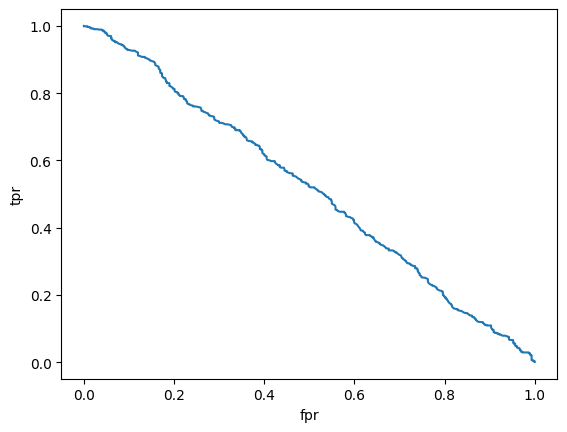

In [203]:
fig, ax = plt.subplots()
ax = plt.plot(fpr_, tpr_)
plt.ylabel("tpr")
plt.xlabel("fpr")
plt.savefig("./plots/precision_recall_experiment1.png")


Text(0.5, 0, 'threshold')

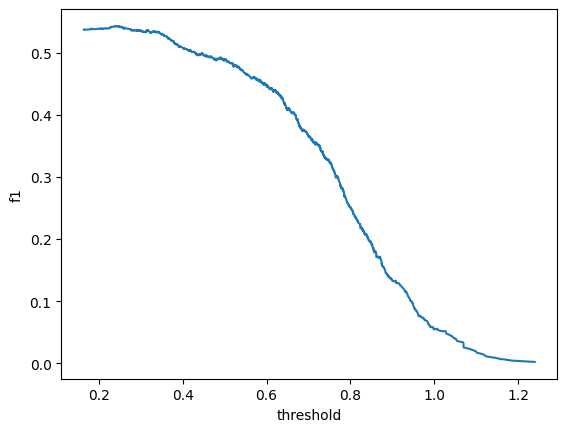

In [204]:
f1 = []
for threshold in list(df["euclidean_distance"].unique()):
    metric = metrics(
        df, 
        'euclidean_distance', 
        'froad', 
        threshold
    )
    acc = metric.f1()
    f1.append(acc)
fig, ax = plt.subplots()
ax = plt.plot(
    list(df["euclidean_distance"].unique()), 
    f1
)
plt.ylabel("f1")
plt.xlabel("threshold")
# plt.savefig("./plots/f1_metric_experiment1.png")

### В общем и целом, можно сказать, что результаты ни к чему не привели. Скорее всего проблема в выборке фотографий, которые могут быть очень плохие. Возможно, стоит руками выбрать фотографии для следующего теста т.к. фотографии могут быть очень плохого качества.

----

## Эксперимент 2 
### [face recognition](https://pypi.org/project/face-recognition/)

In [205]:
data = pd.read_pickle("./face_recognition__exp1.pkl")
df = pd.DataFrame(
    data=data
).T
# выбираю неошибочные значения
df = df.loc[~df.results.isin(errors)].copy()
df["euclidean_distance"] = df.results.apply(lambda x: x['euclidean'])
df.sort_values('euclidean_distance', inplace=True)


In [206]:
print(df.shape)
print(df.froad.sum())
df.head()

(9544, 7)
3552


,person_1,person_1_photo,person_2,person_2_photo,results,froad,euclidean_distance
7017,n000057,0294_01.jpg,n000057,0139_01.jpg,{'euclidean': 0.0},0,0.0
2275,n000091,0272_03.jpg,n000091,0107_01.jpg,{'euclidean': 0.0},0,0.0
6861,n000026,0273_01.jpg,n000023,0398_02.jpg,{'euclidean': 0.0},1,0.0
6854,n000006,0368_02.jpg,n000006,0004_05.jpg,{'euclidean': 0.0},0,0.0
6844,n000006,0004_05.jpg,n000006,0107_01.jpg,{'euclidean': 0.0},0,0.0


In [232]:
tpr = []
fpr = []
for threshold in np.arange(start=0, stop=max(df.euclidean_distance), step=0.001):
    metric = metrics(
        df, 
        'euclidean_distance', 
        'froad', 
        threshold
    )
    tpr_, fpr_ = metric.roc()
    tpr.append(tpr_)
    fpr.append(fpr_)

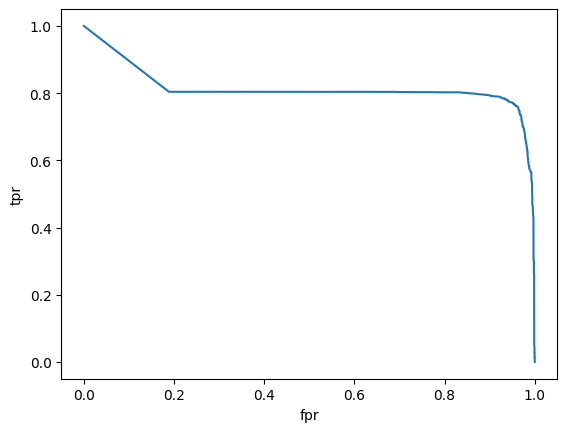

In [233]:
fig, ax = plt.subplots()
ax = plt.plot(fpr, tpr)
plt.ylabel("tpr")
plt.xlabel("fpr")
plt.savefig("./plots/precision_recall_experiment2.png")

In [227]:
f1 = []
for threshold in np.arange(start=0, stop=max(df.euclidean_distance), step=0.001):
    metric = metrics(
        df, 
        'euclidean_distance', 
        'froad', 
        threshold
    )
    acc = metric.f1()
    f1.append(acc)

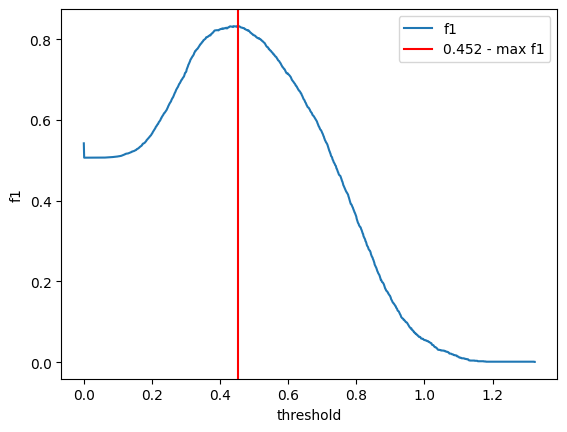

In [228]:
fig, ax = plt.subplots()
threshold = list(
    np.arange(start=0, 
    stop=max(df.euclidean_distance), 
    step=0.001)
)
ax = plt.plot(
    threshold, 
    f1,
    label = "f1"
)
ax = plt.axvline(
    threshold[np.argmax(f1)], 
    color = 'r', 
    label = f"{round(threshold[np.argmax(f1)], 3)} - max f1",
)
plt.legend()
plt.ylabel("f1")
plt.xlabel("threshold")
plt.savefig("./plots/f1_metric_experiment2.png")